# Self-organized criticality in code repositories

### Python script to determine git repository file changes per commit

Uses gitpython library (that makes Git subprocess calls), as an interface for git commands. A reverse list of commits is retrieved and then iterated through to calculate file differences each commit. 

The results are saved as a .csv file with 2 columns, one for the commit delta and the other column notes the author of the commit.

#### TODO

- Add commit author names as column

#### Authors: 
- Mathijs
- Esra
- Koen
- Natasja
- Linda

In [107]:
### IMPORTS ###
import git
import numpy as np
import re
import shutil
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
out_dir = './repo_diff_results/'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [3]:
# Git repository URLS to clone from:
REPOS = {'repo': {'url': 'https://github.com/PerlDancer/Dancer2',
        'file_spec': ['*.t', '*.pm', '*.tt']}
       }
# REPOS = {'repo': {'url': 'https://github.com/EpistasisLab/tpot',
#         'file_spec': ['*.py']}
#        }
REPOS_count = len(REPOS.keys())

In [4]:
# Clone the repositories
for i, repo in enumerate(REPOS.keys()):
    repo_url = REPOS[repo]['url']
    print('Cloning repo ' + repo_url.split('/')[-1] + '...')
    if not os.path.exists('./repo_{}'.format(i)):
        git.Repo.clone_from(repo_url, './repo_{}'.format(i))
print('{} repositories cloned succesfully.'.format(REPOS_count))

Cloning repo Dancer2...
1 repositories cloned succesfully.


In [15]:
# For every repo
for i, repo in enumerate(REPOS.keys()):
    # Get repo info
    repo_url = REPOS[repo]['url']
    repo_name = repo_url.split('/')[-1]
    file_spec = REPOS[repo]['file_spec']
    print('Creating dataframe for ' + repo_name + '...')
    # Create repo
    repo = git.Repo('./repo_{}'.format(i))
    # Get commits, pop first commit, order in chronological order
    cmd = ['--all', '--'] + file_spec
    commits = repo.git.rev_list(cmd).split('\n')
    # Throw away first commit
    commits.pop()
    # Iteration preperation
    prev_commit = commits.pop()
    commits.reverse()
    # Get data
    data = pd.DataFrame({'Changes': []})
    for commit in commits:
        cmd = ['--shortstat', commit + '..' + prev_commit, '--'] + file_spec
        # Get difference from previous and current repo
        content = repo.git.diff(cmd)
        # Use regex to get numbers for inserts vs deletions
        insertion_change = re.search('(\d+)\s+insertion\S+', content)
        insertions = int(insertion_change.group(1)) if insertion_change is not None else 0
        deletions_change = re.search('(\d+)\s+deletion\S+', content)
        deletions = int(deletions_change.group(1)) if deletions_change is not None else 0
        lines_changed = insertions if insertions > deletions else deletions
        # Append
        data = data.append({'Changes': lines_changed}, ignore_index=True)
        prev_commit = commit
    data.to_csv(out_dir + repo_name + '_' + ('_ '.join(file_spec)).replace('*.', '') + '.csv', index=False)
    print(repo_name + ' has been saved succesfully!')

Creating dataframe for Dancer2...
Dancer2 has been saved succesfully!


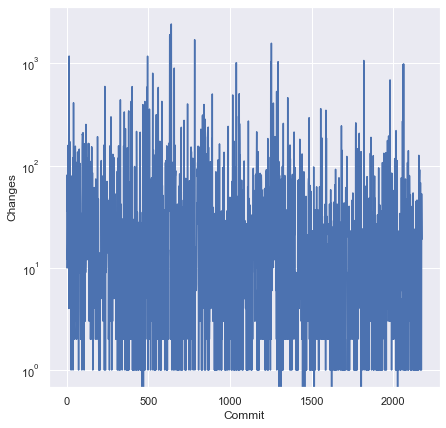

In [17]:
for i, repo in enumerate(REPOS.keys()):
    # Get repo info
    repo_url = REPOS[repo]['url']
    repo_name = repo_url.split('/')[-1]
    file_spec = REPOS[repo]['file_spec']
    df = pd.read_csv(out_dir + repo_name + '_' + '_ '.join(file_spec).replace('*.', '') + '.csv')
    df['Commit'] = range(len(df.index))
    f, ax = plt.subplots(figsize=(7, 7))
    ax.set(yscale="log")
    sns.lineplot(x='Commit', y='Changes', data=df)

In [46]:
df.head()

,Changes,Commit
0,10.0,0
1,17.0,1
2,81.0,2
3,36.0,3
4,59.0,4


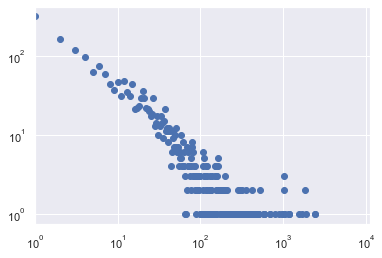

In [73]:
counts = df.groupby('Changes').count()
plt.scatter(x=counts['Commit'].index.values, y= counts['Commit'].values)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1)
# plt.ylim(1, 10000)
plt.show()

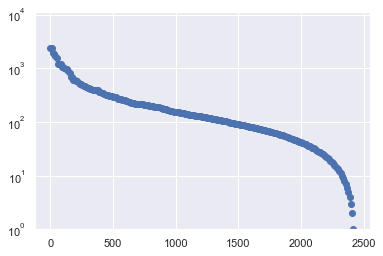

In [86]:
ranks = np.linspace(1, max(counts['Commit'].index.values), 238)
cnt = counts['Commit'].index.values
indices = np.argsort(-cnt)
frequencies = cnt[indices]
plt.scatter(ranks, frequencies)
plt.yscale('log')
plt.ylim(bottom=1)
plt.show()

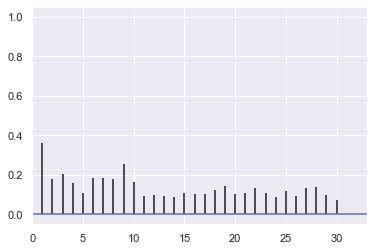

In [102]:
# Plot autocorrelation
plt.acorr(df['Changes'], maxlags=30)
plt.xlim(left=0)
plt.show()

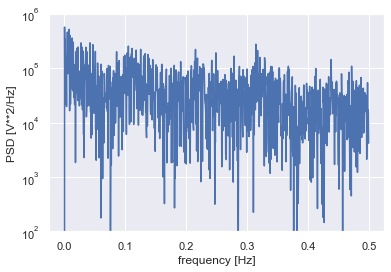

In [112]:
f, Pxx_den = signal.periodogram(df['Changes'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e2, 1e6])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
# Clean up / remove the cloned repositories
# for i in range(REPOS_count):
#     shutil.rmtree('repo_{}'.format(i))